In [3]:
import numpy as np

# Load the NPZ file
data = np.load('../data/embedding_data/unspsc_embeddings.npz')
unspsc_data = [data[f] for f in data.files]

In [4]:
import pickle

# Open the .pickle file for reading
with open('../data/embedding_data/unspsc_title_list.pickle', 'rb') as file:
    unspsc_titles = pickle.load(file)

In [5]:
import pandas as pd
unspsc_pd = pd.DataFrame({"UNSPSC Title": unspsc_titles, "unspsc_emb": unspsc_data})

In [6]:
from TendersWA.Preprocessing import Text as text
import pandas as pd

tenders_structured_path = r"../data/UpdatedAgainTenders.xlsx"

tenders_structured = pd.read_excel(tenders_structured_path, dtype={"Reference Number": str})
tenders_structured = tenders_structured[["Reference Number", "Contract Title", "Description", "UNSPSC Title"]].dropna(subset=["Reference Number"]).drop_duplicates(subset=["Reference Number"])

docs = []
for index, row in tenders_structured.iterrows():
    title = row["Contract Title"]
    desc = text.remove_html_tags(row["Description"])
    tenders_structured.at[index, "Description"] = desc
    docs.append(title + ". " + desc)

In [7]:
import numpy
st_embs = numpy.load("../data/embedding_data/sent_transformer_embeddings.npz")
st_embs = [st_embs[f] for f in st_embs.files]

tender_refs = open("../data/embedding_data/tender_references.txt", "r")
content = ""
for line in tender_refs:
    content = line
    break
    
content = content.replace("[", "")
content = content.replace("'", "")
content = content.replace(",", "")
content = content.replace("]", "")
refs = content.split(" ")

In [8]:
embeddings = pd.DataFrame({"Reference Number": refs, "embedding": st_embs})

In [9]:
combined = pd.merge(tenders_structured, unspsc_pd, on = "UNSPSC Title", how = "left")
combined = pd.merge(combined, embeddings, on = "Reference Number", how = "left")
combined = combined.reset_index(drop=True)

In [10]:
#unpack arrays 
unspsc_emb_np = combined[["unspsc_emb"]].values
unspsc_emb_np = np.block([[unpacked[0]] for unpacked in unspsc_emb_np])
emb_np = combined[["embedding"]].values
emb_np = np.block([[unpacked[0]] for unpacked in emb_np])

In [11]:
print(np.shape(unspsc_emb_np))
print(np.shape(emb_np))

(20619, 768)
(20619, 768)


In [12]:
from sklearn.metrics.pairwise import cosine_similarity
unspsc_emb_dist = cosine_similarity(unspsc_emb_np)

In [13]:
emb_dist = cosine_similarity(emb_np)

In [14]:
divergence = unspsc_emb_dist - emb_dist

In [15]:
divergence_argsorted = np.argsort(divergence, axis = None)

In [29]:
from IPython.display import HTML

def display_tenders(df):
    display(HTML((df[["Reference Number", "Contract Title", "UNSPSC Title", "Description"]].to_html(index = False))))
    
def display_tender_from_div_i(i):
    emb_d = np.shape(emb_np)[0]
    row = i % emb_d
    col = i // emb_d
    display_tenders(combined.loc[[row,col]])
    display(HTML(f"<h4>Divergence: {divergence[row, col]}</h4>"))

In [31]:
display_tender_from_div_i(divergence_argsorted[0])

Reference Number,Contract Title,UNSPSC Title,Description
FINW0184422,Main Roads Western Australia - South Hedland Office - 12 - 16 Brand Street - New garrison fencing to site including automatic gate entry and exit,Fencing,"Main Roads Western Australia - South Hedland Office - 12 - 16 Brand Street - New garrison fencing to site including automatic gate entry and exit A non-mandatory site inspection and/or tender briefing will be held at 12 - 16 Brand Street, South Hedland on Thursday, 25 May 2023 at 2pm. The tender briefing will provide tenderers the opportunity to clarify any tender enquiries they have in relation to the tender in person prior to the closing of the tender. Attendance is not mandatory. To confirm attendance at this briefing, you must contact: Wesley McClay Phone: (08) 6551 1259 Email: wesley.mcclay@finance.wa.gov.au"
FINW0223120,Western Australia Police Force - South Hedland Police Station - Replacement of all the station carpet,Workstations and office packages,"Western Australia Police Force - South Hedland Police Station - Replacement of all the station carpet A non-mandatory tender meeting and/or site inspection, will be held on Friday the 16th of Oct 2020 at South Hedland Police Station commencing at 9am . Tenderer attendance is optional. The tender briefing will provide tenderers the opportunity to clarify any tender enquiries they have in relation to the tender in person prior to the closing of the tender. To confirm attendance at this briefing, you must contact: Shannon Campbell shannon.campbell@finance.wa.gov.au on 0448 931 148 or 9172 6605."


In [18]:
flattened_divs = divergence.flatten()

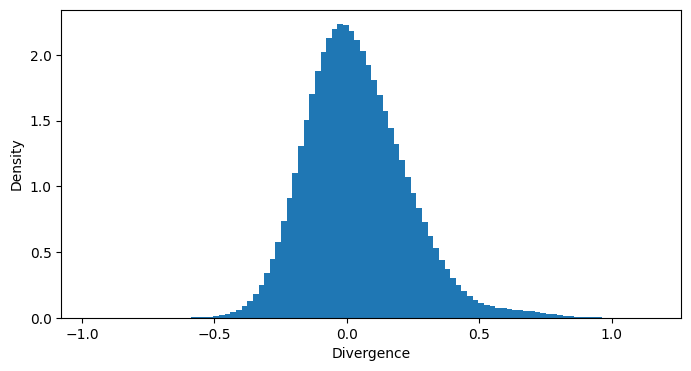

In [26]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.hist(flattened_divs, density = True, bins = 100)
plt.xlabel("Divergence")
plt.ylabel("Density")
plt.show()